In [1]:
%load_ext autoreload
%autoreload 2

import compression as C
import backports.lzma as lzma
import numpy as np

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

# Load the whole stack
ac3 = C.Util.load_data('ac3', -1, '/Volumes/VIS2016/ac3/rhoana/')

# maybe this can be tuned
LZMA_filters = [{"id": lzma.FILTER_LZMA1, "preset": lzma.PRESET_EXTREME}]


/Users/Fritz/Virtualenvs/cs222/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
rle_ids = C.RLE.encode(ac3)[4::2]

In [48]:
# Daniel's
_, _, _, ids = C.SRLE.encode(ac3[0])
com_size = C.Util.get_size(
    C.LZMA.compress(
        C.Pack.encode(ids)[1],
        format=lzma.FORMAT_RAW,
        filters=LZMA_filters
    )
)

print 'Size:', com_size, 'Len', len(ids)

Size: 2987 Len 1024


Compressed RLE IDs 3314
Compressed Hashed RLE IDs 2926
Compressed Hash table 759
Compressed Hashed RLE IDs (inkl. hash table) 3751


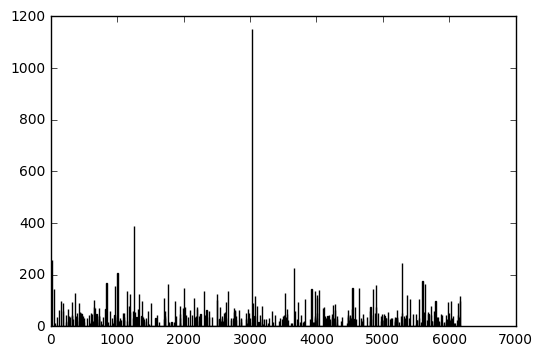

In [35]:
rle_ids = C.RLE.encode(ac3[0:1])[5::2]
u_ids, h_ids = C.HashNums.hash(rle_ids)

assert (np.array_equal(rle_ids, C.HashNums.unhash(u_ids, h_ids)))

com_ids = C.LZMA.compress(rle_ids.tobytes(), format=lzma.FORMAT_RAW, filters=LZMA_filters)
com_h_ids = C.LZMA.compress(h_ids.tobytes(), format=lzma.FORMAT_RAW, filters=LZMA_filters)
com_u_ids = C.LZMA.compress(u_ids.tobytes(), format=lzma.FORMAT_RAW, filters=LZMA_filters)
com_u_h_ids = C.LZMA.compress(u_ids.tobytes() + h_ids.tobytes(), format=lzma.FORMAT_RAW, filters=LZMA_filters)

plt.hist(rle_ids, bins=range(min(rle_ids), max(rle_ids)))
plt.show

print 'Compressed RLE IDs', C.Util.get_size(com_ids)
print 'Compressed Hashed RLE IDs', C.Util.get_size(com_h_ids)
print 'Compressed Hash table', C.Util.get_size(com_u_ids)
print 'Compressed Hashed RLE IDs (inkl. hash table)', C.Util.get_size(com_u_h_ids)

In [31]:
zz_d_u_ids = C.zigzag.encode(u_ids - np.median(u_ids))

s_com_u_ids = C.Util.get_size(u_ids.astype(np.uint16))
s_com_zz_d_u_ids = C.Util.get_size(C.zigzag.encode(u_ids - np.median(u_ids)))
s_com_u_ids = C.Util.get_size(C.LZMA.compress(u_ids))
s_com_zz_d_u_ids = C.Util.get_size(C.LZMA.compress(C.zigzag.encode(u_ids - np.median(u_ids))))

print max(u_ids), max(zz_d_u_ids)
print s_u_ids, s_zz_d_u_ids, s_com_u_ids, s_com_zz_d_u_ids

6178 6278
816 820 816 820


<function matplotlib.pyplot.show>

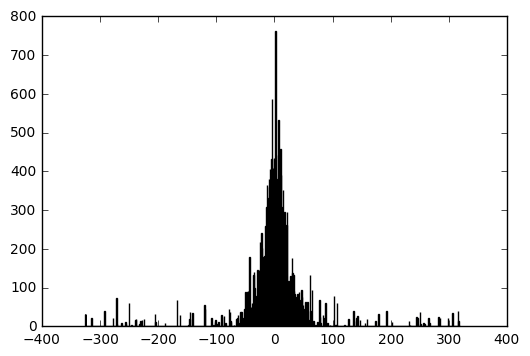

In [6]:
delta_h_ids = np.append(
    h_ids[0],
    np.diff(h_ids)
)
plt.hist(delta_h_ids, bins=range(min(delta_h_ids), max(delta_h_ids)))
plt.show

In [14]:
delta_h_ids

array([  0,   1,   1, ...,  -3,  -6, -63])

2506 4290 3535


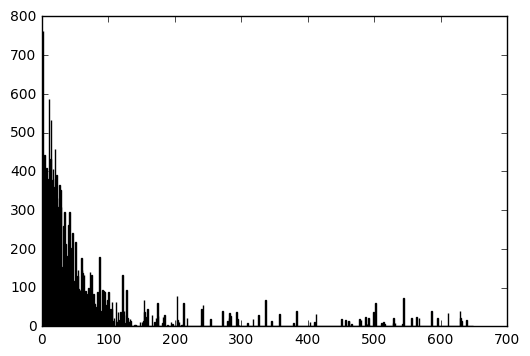

In [19]:
zz_delta_h_ids = C.zigzag.encode(delta_h_ids)

s_h_ids = C.Util.get_size(C.LZMA.compress(h_ids.astype(np.uint16), format=lzma.FORMAT_RAW, filters=LZMA_filters))
s_delta_h_ids = C.Util.get_size(C.LZMA.compress(delta_h_ids, format=lzma.FORMAT_RAW, filters=LZMA_filters))
s_zz_delta_h_ids = C.Util.get_size(C.LZMA.compress(zz_delta_h_ids.astype(np.uint16), format=lzma.FORMAT_RAW, filters=LZMA_filters))

plt.hist(zz_delta_h_ids, bins=range(min(zz_delta_h_ids), max(zz_delta_h_ids)))
plt.show

print s_h_ids, s_delta_h_ids, s_zz_delta_h_ids

In [17]:
max(zz_delta_h_ids)

650

3592

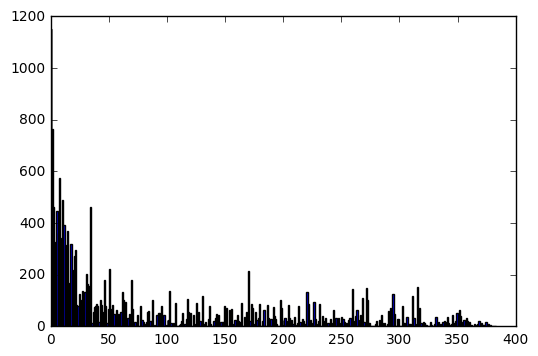

In [40]:
delta_nodelta_mixed_h_ids = np.copy(delta_h_ids)
neg_idx, = np.where(delta_h_ids < 0)
delta_nodelta_mixed_h_ids[neg_idx] = h_ids[neg_idx]
delta_nodelta_mixed_h_ids = delta_nodelta_mixed_h_ids.astype(np.uint)

plt.hist(delta_nodelta_mixed_h_ids, bins=range(min(delta_nodelta_mixed_h_ids), max(delta_nodelta_mixed_h_ids)))
plt.show

C.Util.get_size(C.LZMA.compress(delta_nodelta_mixed_h_ids.tobytes(), format=lzma.FORMAT_RAW, filters=LZMA_filters))

In [81]:
total_bytes = 0

ui8, ui16, ui32, ui64 = C.Extract.encode(delta_nodelta_mixed_h_ids)

print len(ui8), len(ui16), len(ui32), len(ui64)

total_bytes += C.Util.get_size(C.LZMA.compress(ui8, format=lzma.FORMAT_RAW, filters=LZMA_filters))
total_bytes += C.Util.get_size(C.LZMA.compress(ui16, format=lzma.FORMAT_RAW, filters=LZMA_filters))
# total_bytes += C.Util.get_size(C.LZMA.compress(ui32, format=lzma.FORMAT_RAW, filters=LZMA_filters))
# total_bytes += C.Util.get_size(C.LZMA.compress(ui64, format=lzma.FORMAT_RAW, filters=LZMA_filters))

print 'Total after packing (8 and 16 bits)', total_bytes
print 'Total everything in 16 bits', C.Util.get_size(C.LZMA.compress(delta_nodelta_mixed_h_ids.astype(np.uint16), format=lzma.FORMAT_RAW, filters=LZMA_filters))

20555 2792 0 0
Total after packing (8 and 16 bits) 3434
Total everything in 16 bits 3158


In [66]:
np.iinfo(np.uint8)

iinfo(min=0, max=255, dtype=uint8)

In [67]:
np.uint8.max

<method 'max' of 'numpy.generic' objects>

In [74]:
all = C.RLE.encode(ac3[0:1])
print len(all), all.shape
h = all[:3]
rl = all[3::2]
ids = all[4::2]

41113 (41113,)


In [78]:
C.Util.get_size(C.LZMA.compress(all, format=lzma.FORMAT_RAW, filters=LZMA_filters))

15454

In [83]:
from bitstring import BitArray, BitStream
egc_ids = BitStream().join([BitArray(se=i) for i in delta_h_ids])
C.Util.get_size(C.LZMA.compress(all, format=lzma.FORMAT_RAW, filters=LZMA_filters))

202995